In [ ]:
import torch
import numpy as np
import normflows as nf

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.dirname(c_directory))
import BSCD_simulator

from matplotlib import pyplot as plt
from eZplot import BSCD_plot
from tqdm import tqdm

N = 2**12

seed_data = 42
seed_mcmc= 13
torch.manual_seed(seed_mcmc)


enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BSCD_simulator.adjust_device(device)

model_file = 'BSCD_network.pt'

In [2]:
# Define target
target = BSCD_simulator.target()
context_size = 5

In [3]:
# Define flows
latent_size = 1
hidden_units = 128
hidden_layers = 5

flows = [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 64,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 128,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size),      
         nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, 256,num_context_channels=context_size,tail_bound=30),
         nf.flows.LULinearPermute(latent_size)
         ]
# Set base distribution
q0 = nf.distributions.DiagGaussian(1)#, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows, target)

# Move model on GPU if available
model = model.to(device)


for param in model.parameters():
    param.requires_grad = False

In [4]:
try:
    model.load_state_dict(torch.load(model_file))
    #model.eval()  # Set the model to evaluation mode
    print('loading pretrained network')
except:
    print('starting from scratch')

loading pretrained network


In [5]:
dv = np.loadtxt('BSCD_synth/gt_map.csv')
gt = torch.tensor( dv[ dv[:,0]==seed_data ][0,1:] , device=device,dtype=torch.float)

x = np.loadtxt('BSCD_synth/synth_{}.csv'.format(seed_data))[:N]
x = torch.tensor(x,device=device,dtype=torch.float).reshape(-1,1)
gt

tensor([ 5.1940, 10.1614, -0.1721,  0.8491, -2.7811], device='cuda:0')

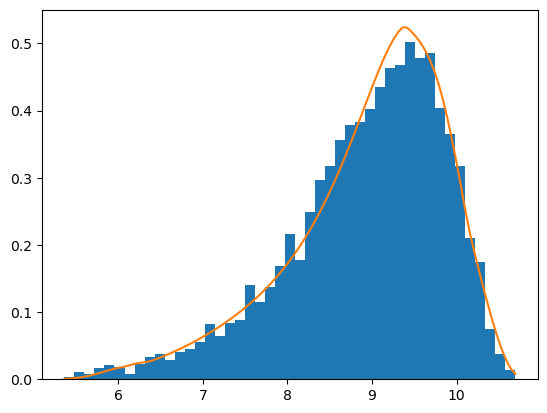

In [6]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=45)

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,5),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu())

In [7]:
vectorize_params = torch.ones(1024,5).to(device)

def log_likelihood(data,params,model):
    global vectorize_params
    if data.size !=  vectorize_params.size(0):
        vectorize_params = torch.ones((data.size(0),5),device=device)

    return model.log_prob(data,params*vectorize_params)

def log_post(data,params,model,lprior):
    return log_likelihood(data,params,model).sum() + lprior(params)


In [8]:
lp_gt = log_post(x,gt,model,target.log_prior)
lp_gt

tensor(-5151.3838, device='cuda:0')

In [9]:
#first 100 from prior
params_100 = target.sample(n=100)[:,1:]
best_param = params_100[0]
lp_max = log_post(x,best_param,model,target.log_prior)

for par in params_100[1:]:
    lp_par = log_post(x,par,model,target.log_prior)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par

for i in range(3,8):

    params_100 = (target.sample(n=100)[:,1:] - best_param)/i +best_param

    for par in params_100:
        lp_par = log_post(x,par,model,target.log_prior)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 4.4811, 10.0009, -0.0216,  1.1226, -1.9090], device='cuda:0') tensor(-5426.7559, device='cuda:0')
tensor([ 4.6939,  9.8163, -0.1889,  0.5619, -2.0300], device='cuda:0') tensor(-5285.1440, device='cuda:0')
tensor([ 4.4937,  9.9372, -0.0286,  0.8542, -2.0100], device='cuda:0') tensor(-5241.8926, device='cuda:0')
tensor([ 4.3297e+00,  9.9761e+00, -4.7523e-03,  5.9484e-01, -2.2308e+00],
       device='cuda:0') tensor(-5231.5229, device='cuda:0')
tensor([ 4.4224,  9.9460,  0.0458,  0.6850, -2.3042], device='cuda:0') tensor(-5223.3491, device='cuda:0')
tensor([ 4.8436,  9.8382, -0.2732,  0.3695, -2.2973], device='cuda:0') tensor(-5176.9937, device='cuda:0')
tensor([ 4.5517,  9.9872, -0.0807,  0.6273, -2.2300], device='cuda:0') tensor(-5175.2334, device='cuda:0')
tensor([ 4.5872,  9.9624, -0.1436,  0.5721, -2.2184], device='cuda:0') tensor(-5159.0234, device='cuda:0')


In [10]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [11]:
S = torch.eye(5)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(5,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(5,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [12]:
count_of_safe=0
loopruns = 0

while count_of_safe <=10:
    for i in range(100):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,model,target.log_prior)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-100:]).T.cov() + torch.eye(5)*1e-10) * (2.4**2/(context_size)) )
    loopruns+=1

    print(loopruns,acc_rate)
    



1 0.47
2 0.65
3 0.6
4 0.44
5 0.48
6 0.56
7 0.34
8 0.28
9 0.42
10 0.32
11 0.31
12 0.27
13 0.37
14 0.28
15 0.31
16 0.29
17 0.28


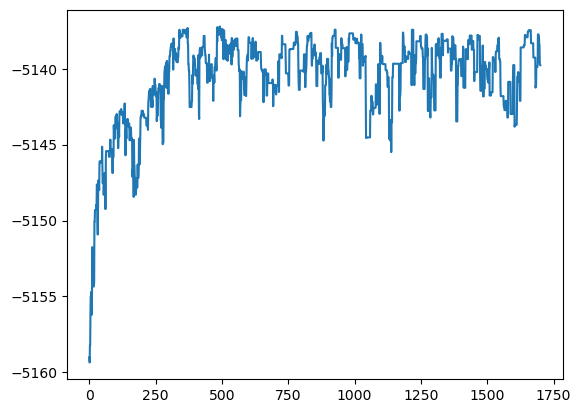

In [13]:
plt.plot(sampled_logpost)

In [14]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,model,target.log_prior)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)

99 tensor([ 5.0792, 10.0562, -0.2379,  0.7080, -2.1454], device='cuda:0') tensor(-5139.6782, device='cuda:0')
199 tensor([ 4.7950, 10.1424, -0.1077,  0.9386, -2.0313], device='cuda:0') tensor(-5139.3901, device='cuda:0')
299 tensor([ 4.8725, 10.1155, -0.2146,  0.7902, -2.2780], device='cuda:0') tensor(-5140.5796, device='cuda:0')
399 tensor([ 4.8055, 10.0678, -0.1469,  0.7937, -2.1687], device='cuda:0') tensor(-5138.8213, device='cuda:0')
499 tensor([ 4.9553, 10.0694, -0.1681,  0.7939, -1.9680], device='cuda:0') tensor(-5137.9478, device='cuda:0')
599 tensor([ 4.9651,  9.9927, -0.2239,  0.5857, -2.1725], device='cuda:0') tensor(-5141.6382, device='cuda:0')
699 tensor([ 4.8833, 10.1465, -0.1433,  0.9219, -1.9308], device='cuda:0') tensor(-5138.1284, device='cuda:0')
799 tensor([ 4.7653, 10.0681, -0.1455,  0.7715, -2.2352], device='cuda:0') tensor(-5139.9829, device='cuda:0')
899 tensor([ 4.8382, 10.0056, -0.2215,  0.6330, -2.4367], device='cuda:0') tensor(-5140.8521, device='cuda:0')
99

KeyboardInterrupt: 

In [15]:
np.savetxt('BSCD_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed_mcmc,seed_data,N),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

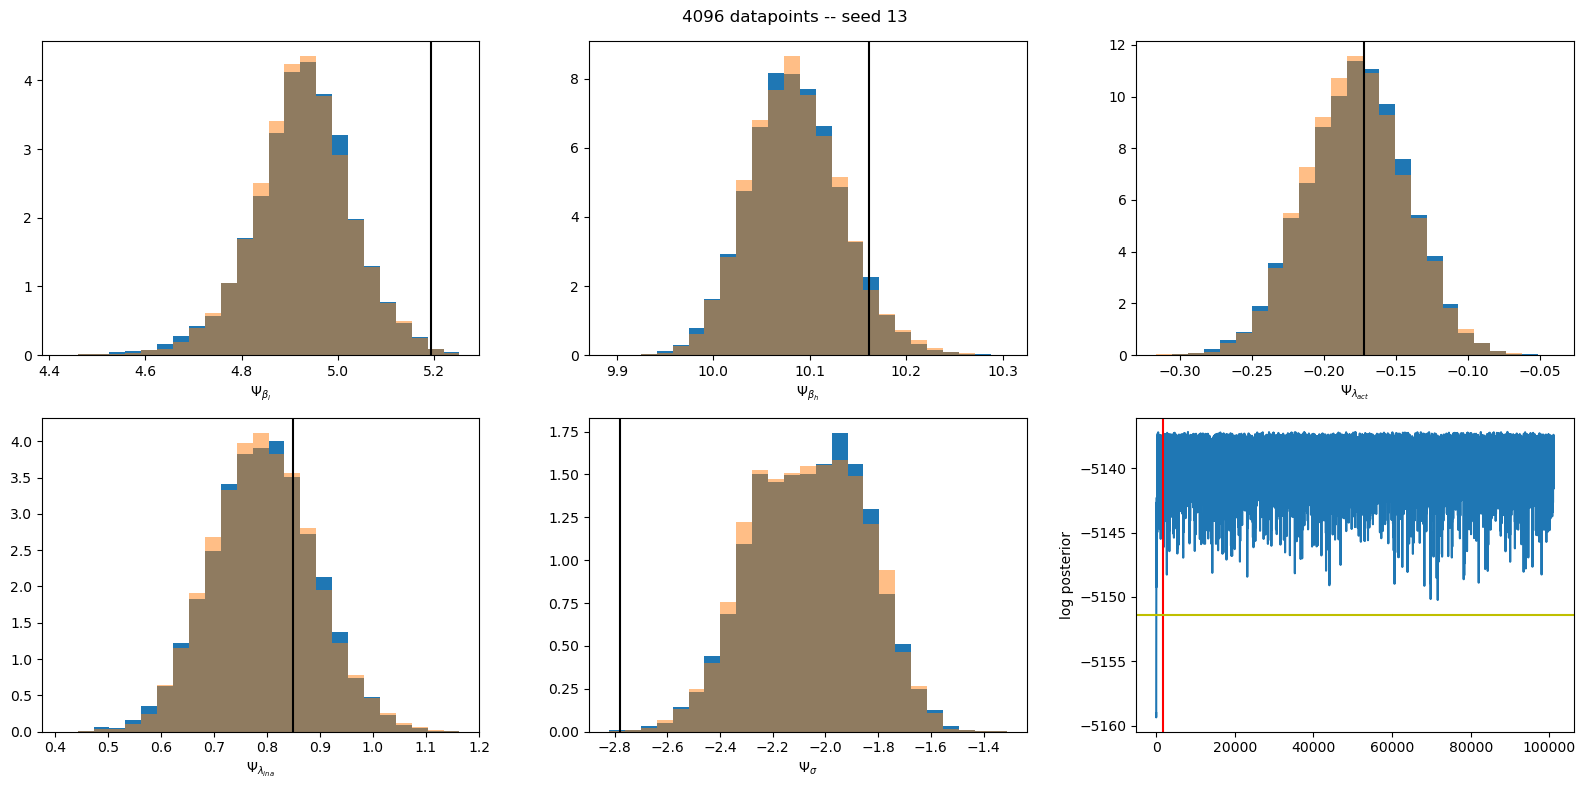

In [16]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
labels = [r'$\Psi_{\beta_l}$',r'$\Psi_{\beta_h}$',r'$\Psi_{\lambda_{act}}$',r'$\Psi_{\lambda_{ina}}$',r'$\Psi_\sigma$']
sp = torch.stack(sampled_params).numpy()

for (i,axi) in zip(range(5),np.concatenate((ax))):
    his = axi.hist(sp[burnin:burnin+sp.shape[0]//2,i],density=True,bins=25)
    axi.hist(sp[burnin+sp.shape[0]//2:,i],density=True,bins=his[1],alpha=.5)
    axi.axvline(gt.cpu()[i].item(),color='k')
    axi.set_xlabel(labels[i])

ax[-1][-1].plot(sampled_logpost)
ax[-1][-1].axvline(burnin,color='red')
ax[-1][-1].axhline(lp_gt.item(),color='y')

ax[-1][-1].set_ylabel('log posterior')

plt.suptitle('{} datapoints -- seed {}'.format(N,seed_mcmc))

plt.tight_layout()
plt.savefig('BSCD_inf_figs/mcmc_noncentral_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)

In [17]:
map_param = sampled_params[np.argmax(sampled_logpost)].to(device)

In [18]:
map_param

tensor([ 4.9288, 10.0826, -0.1839,  0.7815, -2.2401], device='cuda:0')

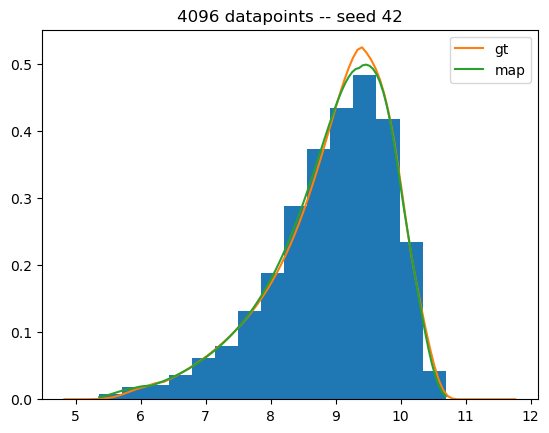

In [19]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=15)

xp = torch.linspace(.9*x.min(),1.1*x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,5),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='gt')

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,5),device=device)*map_param)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='map')
plt.legend()

plt.title('{} datapoints -- seed {}'.format(N,seed_data))

plt.savefig('BSCD_inf_figs/mcmc_compare_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)

In [ ]:
t = torch.distributions.Categorical(torch.tensor([3.14]))

In [ ]:
t.log_prob(t.sample((1,10)))

tensor([[-1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07,
         -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07, -1.1921e-07]])

In [ ]:
torch.log(torch.tensor(.5))

tensor(-0.6931)

In [ ]:

class delta(torch.distributions.Distribution):
    #makes a distribution that always sample x0
    def __init__(self, x0, device='cpu'):
        self.x0 = torch.tensor(x0).to(device)
    
    def sample(self,shape):
        return self.x0 + torch.zeros(shape,device=self.x0.device)
    
    def log_prob(self,x):
        return torch.where(x==self.x0, 0., -torch.inf)



In [ ]:
half = delta(.5)
half = delta(.5,device)

In [ ]:
half.sample((300,100))

tensor([[0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        ...,
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.5000,  ..., 0.5000, 0.5000, 0.5000]],
       device='cuda:0')

In [ ]:
half.log_prob(half.sample((300,100)))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

In [ ]:
half.log_prob(torch.randn(3,2).to(device))

tensor([[-inf, -inf],
        [-inf, -inf],
        [-inf, -inf]], device='cuda:0')

In [ ]:
torch.inf

inf

In [ ]:
half.sample()

TypeError: sample() missing 1 required positional argument: 'shape'

In [ ]:
x.size()

torch.Size([1024, 1])